### import des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

### import du dataset

In [2]:
df = pd.read_csv('..\data_final\dataset_without_outliers.csv', index_col=0)
df1 = pd.read_csv('..\data_final\dataset_with_outliers.csv', index_col=0)

In [4]:
def prepare(df):
    df['casting_score_mean'] = df['casting_score_mean'].map(int)
    df.drop(columns = ['titre', 'realisateur', 'casting', 'compagnies_production', 
        'recette', 'director_score_mean', 'director_score_med',
        'director_score_min', 'director_score_max',
        'compagnies_score_mean', 'compagnies_score_med', 'compagnies_score_min',
        'compagnies_score_max'], inplace = True)
    return df

prepare(df)
prepare(df1)

,budget,duree,suite,Comedy,Drama,Horror,Thriller,Action,Adventure,Science Fiction,...,TV Movie,saison,benefice global,casting_score_sum,casting_score_mean,casting_score_med,casting_score_min,casting_score_max,director_score_sum,compagnies_score_sum
0,40000000,110,3,1,0,0,0,0,0,0,...,0,2,324.592525,79,1,0,0,38,27,135
1,2000000,100,1,1,1,0,0,0,0,0,...,0,2,-88.000000,0,0,0,0,0,0,0
2,170000000,136,2,0,0,0,0,1,1,1,...,0,0,320.450925,459,7,0,0,100,128,81
3,4000000,80,1,1,0,0,0,0,0,0,...,0,3,148.456700,0,0,0,0,0,0,0
4,12000000,95,1,0,1,0,0,0,1,0,...,0,0,-92.608333,5,0,0,0,5,4,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7851,10000,91,1,0,1,0,0,0,0,0,...,0,1,0.000000,0,0,0,0,0,0,0
7852,300,0,1,0,1,0,0,0,0,0,...,0,1,-99.666667,0,0,0,0,0,0,0
7853,16000,70,1,0,1,0,1,0,0,0,...,0,3,25.000000,0,0,0,0,0,0,0
7854,75,75,1,0,0,0,0,0,0,0,...,0,0,0.000000,0,0,0,0,0,0,0


### Librairies pour la prédiction

In [5]:
from random import shuffle
from sklearn import tree, preprocessing, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score


### Création de catégorie de bénéfice global

In [6]:
df.describe()['benefice global']

count     4695.000000
mean       214.418103
std        562.548423
min        -98.965390
25%        -29.184778
50%         77.704300
75%        260.048464
max      12400.282100
Name: benefice global, dtype: float64

In [10]:
def construction_tranche(df):
    df['tranche benef'] = 0
    df.loc[df['benefice global'] >= df['benefice global'].quantile(0.25), 'tranche benef'] = 1
    df.loc[df['benefice global'] >= df['benefice global'].quantile(0.5), 'tranche benef'] = 2
    df.loc[df['benefice global'] >= df['benefice global'].quantile(0.75), 'tranche benef'] = 3
    df['tranche benef binaire'] = 0
    df.loc[df['benefice global'] > 0, 'tranche benef binaire'] = 1
    df['tranche benef binaire'].value_counts()
    return df

construction_tranche(df)
construction_tranche(df1)

,budget,duree,suite,Comedy,Drama,Horror,Thriller,Action,Adventure,Science Fiction,...,benefice global,casting_score_sum,casting_score_mean,casting_score_med,casting_score_min,casting_score_max,director_score_sum,compagnies_score_sum,tranche benef,tranche benef binaire
0,40000000,110,3,1,0,0,0,0,0,0,...,324.592525,79,1,0,0,38,27,135,2,1
1,2000000,100,1,1,1,0,0,0,0,0,...,-88.000000,0,0,0,0,0,0,0,0,0
2,170000000,136,2,0,0,0,0,1,1,1,...,320.450925,459,7,0,0,100,128,81,2,1
3,4000000,80,1,1,0,0,0,0,0,0,...,148.456700,0,0,0,0,0,0,0,2,1
4,12000000,95,1,0,1,0,0,0,1,0,...,-92.608333,5,0,0,0,5,4,54,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7851,10000,91,1,0,1,0,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,1,0
7852,300,0,1,0,1,0,0,0,0,0,...,-99.666667,0,0,0,0,0,0,0,0,0
7853,16000,70,1,0,1,0,1,0,0,0,...,25.000000,0,0,0,0,0,0,0,1,1
7854,75,75,1,0,0,0,0,0,0,0,...,0.000000,0,0,0,0,0,0,0,1,0


In [9]:
df['tranche benef'].value_counts()

3    1174
0    1174
2    1174
1    1173
Name: tranche benef, dtype: int64

### creation d'un train et d'un texte

In [11]:
def X_and_Y(df):
    X = df.drop(columns = ['tranche benef', 'benefice global', 'tranche benef binaire'])
    Y = df['tranche benef']
    Y_bin = df['tranche benef binaire']
    return X, Y, Y_bin

X, Y, Y_bin = X_and_Y(df)
X1, Y1, Y1_bin = X_and_Y(df)

division du dataset en un train et un test

In [9]:
"""
    Constant indicating the proportion of the dataset to use as training set.
"""



In [10]:
def train_test(X,Y,Y_bin): 
    TRAINING_SET_RATIO = 0.9    
    ind = [i for i in range(df.shape[0])]
    shuffle(ind)
    X_train=X.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
    Y_train=Y.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
    Y_bin_train=Y_bin.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
    X_test=X.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]
    Y_test=Y.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]
    Y_bin_test=Y_bin.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]
    return X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test

X_train, Y_train, Y_bin_train, X_test, Y_test, Y_bin_test = train_test(X, Y, Y_bin)
X1_train, Y1_train, Y1_bin_train, X1_test, Y1_test, Y1_bin_test = train_test(X1, Y1, Y1_bin)

### méthode du Decision Tree Classifier 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


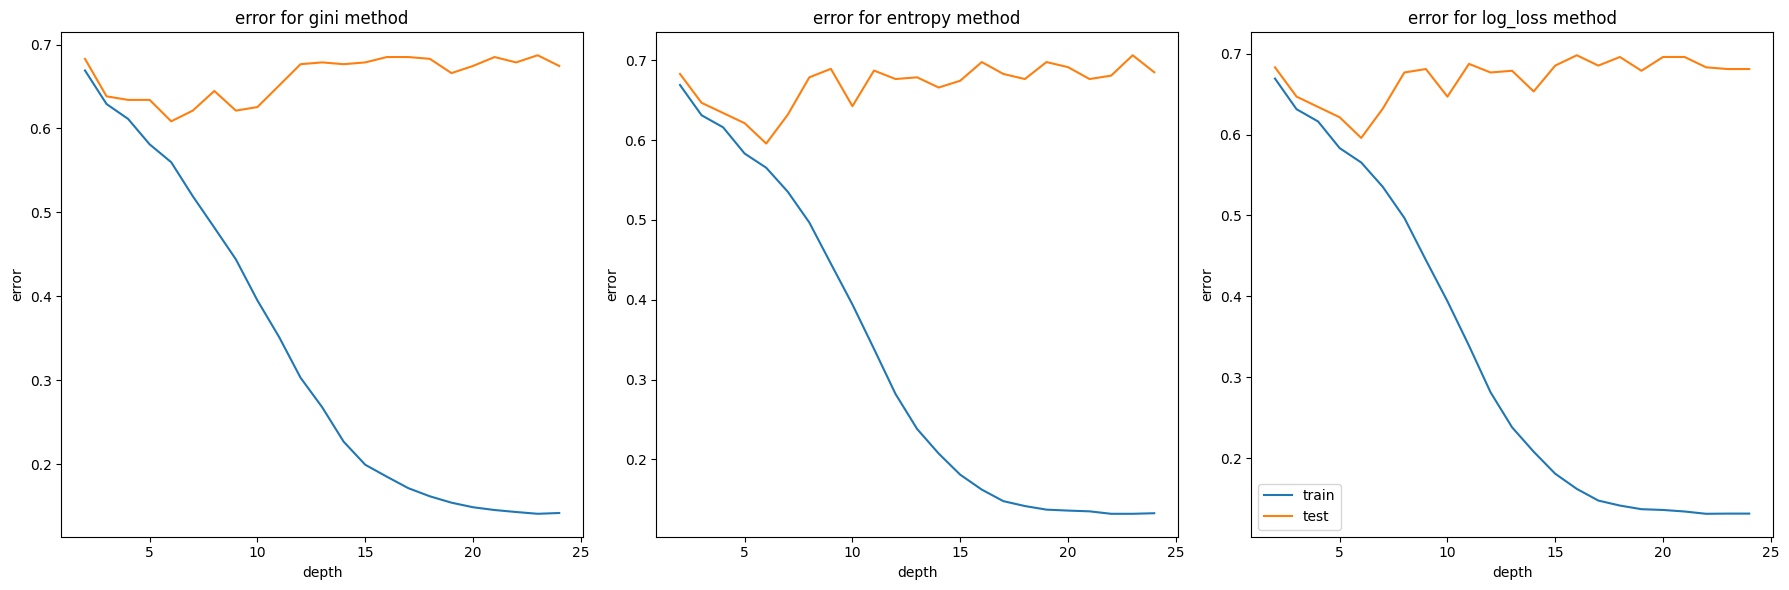

In [11]:
train_scores_dico = {}
test_scores_dico = {}
criteria = ["gini", "entropy", "log_loss"]
for criterion in ["gini", "entropy", "log_loss"]:
    train_scores = []
    test_scores = []
    depths = [i for i in range(2,25)]
    for depth in depths:
        clf = tree.DecisionTreeClassifier(criterion = criterion , max_depth = depth, min_samples_split = 2, min_samples_leaf = 2)
        clf = clf.fit(X_train, Y_train)
        train_score = clf.score(X_train, Y_train)
        train_scores.append(1 - train_score)
        test_score = clf.score(X_test,Y_test)
        test_scores.append(1 - test_score)
    train_scores_dico[criterion] = train_scores
    test_scores_dico[criterion] = test_scores

fig, ax = plt.subplots(1,3, figsize = (18,6))
for i, criterion in enumerate(criteria):
    ax[i].set_title(f'error for {criterion} method')
    ax[i].plot(depths, train_scores_dico[criterion], label=f"train")
    ax[i].plot(depths, test_scores_dico[criterion], label=f"test")
    ax[i].set_xlabel("depth")
    ax[i].set_ylabel("error")
    plt.legend()

fig.tight_layout()
plt.show()

In [12]:
clf = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 5, min_samples_split = 2, min_samples_leaf = 2)
clf.fit(X_train, Y_train)
Y_pred_test = clf.predict(X_test)

In [13]:
confusion_matrix(Y_test, Y_pred_test, labels=[0,1,2,3])

array([[63, 30, 19, 11],
       [41, 24, 39, 17],
       [39, 27, 35, 22],
       [10, 15, 28, 50]], dtype=int64)

In [14]:
print(classification_report(Y_test, Y_pred_test, digits = 4))

              precision    recall  f1-score   support

           0     0.4118    0.5122    0.4565       123
           1     0.2500    0.1983    0.2212       121
           2     0.2893    0.2846    0.2869       123
           3     0.5000    0.4854    0.4926       103

    accuracy                         0.3660       470
   macro avg     0.3628    0.3701    0.3643       470
weighted avg     0.3574    0.3660    0.3595       470



### méthode KNN Classifier

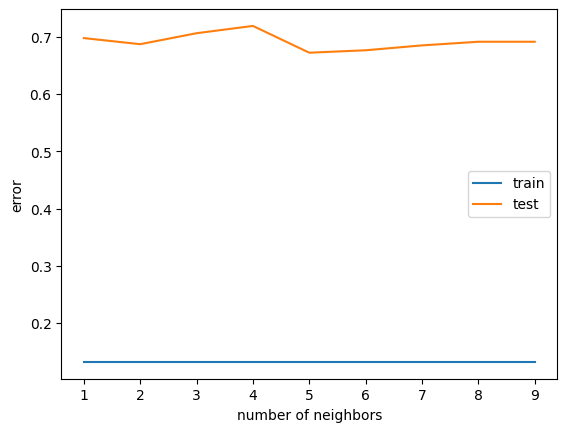

In [15]:
n_neighbors = [n for n in range(1,10)]
test_scores = []
train_scores = []
verify_scores = []

for n in n_neighbors:
    neigh = KNeighborsClassifier(n_neighbors = n)
    neigh.fit(X_train, Y_train)
    score_train = neigh.score(X_train, Y_train)
    score_test = neigh.score(X_test, Y_test)
    train_scores.append(1 - train_score)
    test_scores.append(1 - score_test)

fig, ax = plt.subplots()
ax.plot(n_neighbors, train_scores, label="train")
ax.plot(n_neighbors, test_scores, label="test")
ax.set_xlabel("number of neighbors")
ax.set_ylabel("error")
plt.legend()

In [16]:
neigh = KNeighborsClassifier(n_neighbors = 7)
neigh.fit(X_train, Y_train)
Y_pred_neigh_test = neigh.predict(X_test)

In [17]:
confusion_matrix(Y_test, Y_pred_neigh_test, labels=[0,1,2,3])

array([[60, 31, 20, 12],
       [45, 33, 22, 21],
       [46, 33, 27, 17],
       [33, 22, 20, 28]], dtype=int64)

In [18]:
print(classification_report(Y_test, Y_pred_test, digits = 4))

              precision    recall  f1-score   support

           0     0.4118    0.5122    0.4565       123
           1     0.2500    0.1983    0.2212       121
           2     0.2893    0.2846    0.2869       123
           3     0.5000    0.4854    0.4926       103

    accuracy                         0.3660       470
   macro avg     0.3628    0.3701    0.3643       470
weighted avg     0.3574    0.3660    0.3595       470



### methode du Dummy Classifier

In [19]:
Dum = DummyClassifier()
Dum.fit(X_train, Y_train)
test_score = Dum.score(X_test, Y_test)
print(f'test_score = {test_score}')

test_score = 0.21914893617021278


### methode de la Logistic Regression

création d'un score binaire pour les tranche de benefice globale sur df (0 : film à perte, 1 : film ayant un benefice global positif)

In [21]:
X_bin = df.drop(columns = ['tranche benef', 'benefice global', 'tranche benef binaire'])
Y_bin = df['tranche benef binaire']

In [22]:
ind = [i for i in range(df.shape[0])]
shuffle(ind)
X_train_bin=X_bin.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
Y_train_bin=Y_bin.iloc[ind[:int(TRAINING_SET_RATIO*df.shape[0])]]
X_test_bin=X_bin.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]
Y_test_bin=Y_bin.iloc[ind[int(TRAINING_SET_RATIO*df.shape[0]):]]

In [23]:
stds = preprocessing.StandardScaler()

Z_train = stds.fit_transform(X_train_bin)

print(scipy.stats.describe(Z_train, axis=0, ddof=0))

DescribeResult(nobs=4225, minmax=(array([-0.77602742, -2.2397119 , -0.22773774, -0.72665599, -0.94944202,
       -0.34397176, -0.59913092, -0.62104769, -0.46306526, -0.34697618,
       -0.34697618, -0.35590261, -0.41940145, -0.4626883 , -0.25868744,
       -0.31573353, -0.19318108, -0.18375418, -0.100203  , -0.23717082,
       -0.10375717, -0.03078381, -1.39355323, -0.67224066, -0.56049353,
       -0.05231777, -0.022059  , -0.93345022, -0.50404869, -0.51353639,
       -0.51339585, -0.50995793, -0.51718787, -0.72883143, -0.61042042,
       -0.4513415 , -0.23854234, -0.73196491]), array([ 8.06050417, 10.45022229, 26.54488846,  1.376167  ,  1.05325021,
        2.90721543,  1.66908427,  1.61018231,  2.15952283,  2.88204223,
        2.88204223,  2.80975743,  2.38435035,  2.16128224,  3.86566892,
        3.16722775,  5.17649038,  5.44205311,  9.97974138,  4.21637021,
        9.6378882 , 32.48461174,  1.38587827, 26.4899889 , 28.22621012,
       52.0114287 , 55.5009244 ,  3.25053788,  9.63429

In [24]:
logit = LogisticRegression()

parameters = [{'penalty':['l1','l2']}, 
              {'C':[1, 10, 100, 1000]}]



grid_search = GridSearchCV(estimator = logit,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)


grid_search.fit(Z_train, Y_train_bin)

c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 10, 100, 1000]}],
             scoring='accuracy')

In [25]:
# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))

# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))

# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

GridSearch CV best score : 0.6833


Parameters that give the best results : 

 {'C': 10}


Estimator that was chosen by the search : 

 LogisticRegression(C=10)


In [26]:
logit = LogisticRegression(C=10, max_iter = 60)

#Starting calculations and no need to add the constant
logit.fit(Z_train,Y_train_bin)

# computing OR
print(pd.DataFrame({"var":X_train.columns,"coef":logit.coef_[0], "OR":np.exp(logit.coef_[0])}))

                      var      coef        OR
0                  budget -0.112647  0.893466
1                   duree  0.332143  1.393952
2                   suite  0.407521  1.503086
3                  Comedy  0.113949  1.120695
4                   Drama -0.111106  0.894844
5                  Horror  0.200415  1.221909
6                Thriller -0.010893  0.989166
7                  Action  0.064212  1.066319
8               Adventure -0.010500  0.989555
9         Science Fiction -0.065085  0.936988
10                Fantasy -0.020109  0.980092
11                 Family  0.137058  1.146894
12                  Crime -0.010127  0.989924
13                Romance  0.051753  1.053115
14              Animation  0.013407  1.013497
15                Mystery -0.010920  0.989139
16                    War -0.043272  0.957651
17                  Music -0.028450  0.971950
18                Western -0.085943  0.917646
19                History -0.093763  0.910498
20            Documentary  0.11413

c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
# transforming the test sample

Z_test = stds.transform(X_test)

In [28]:
predlog_test = logit.predict(Z_test)

print(classification_report(Y_test_bin,predlog_test))

              precision    recall  f1-score   support

           0       0.30      0.13      0.18       172
           1       0.62      0.83      0.71       298

    accuracy                           0.57       470
   macro avg       0.46      0.48      0.45       470
weighted avg       0.50      0.57      0.52       470



In [29]:
stds = preprocessing.StandardScaler()

Z = stds.fit_transform(X) 

scores = cross_val_score(logit, Z_train, Y_train_bin, cv = 5, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.67928994 0.70177515 0.67337278 0.67810651 0.68402367]


c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\School_projects\DaSci_project\MovieHype\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

In [30]:
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Average cross-validation score: 0.6833


In [31]:
print('Average cross-validation score: {:.4f}'.format(scores.std()))

Average cross-validation score: 0.0098


### Méthode SVM

In [32]:
# Extract some useful information
num_classes = 4
classes_labels = [0,1,2,3]

# Initialize classfier
clf = svm.SVC()
stds = preprocessing.StandardScaler()
Z_train = stds.fit_transform(X_train)
Z_test = stds.transform(X_test)
clf.fit(Z_train, Y_train_bin)
Y_pred = clf.predict(Z_test)

In [33]:
Y_train_bin.value_counts()

1    2824
0    1401
Name: tranche benef binaire, dtype: int64

In [34]:
print(classification_report(Y_test_bin, Y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.5000    0.0058    0.0115       172
           1     0.6346    0.9966    0.7755       298

    accuracy                         0.6340       470
   macro avg     0.5673    0.5012    0.3935       470
weighted avg     0.5854    0.6340    0.4959       470



In [35]:
def precision_recall_multilabels(y_true, y_pred, labels):
    recalls = []
    precisions = []
    for label in labels:

        pos_true = y_true == label
        pos_pred = y_pred == label

        # By hand
        true_pos = pos_pred & pos_true
        recalls.append(np.sum(true_pos) / np.sum(pos_true))
        precisions.append(np.sum(true_pos) / np.sum(pos_pred))

        # With sklearn
        # precisions.append(precision_score(pos_test, pos_pred))
        # recalls.append(recall_score(pos_test, pos_pred))

    return precisions, recalls

In [36]:
def kfold_multimodels_report(clfs_results: dict[str, dict[str, list[list[float]]]]):
    """
    Prints a report for the results of experiments on multiple models,
    each one evaluated using k-fold cross-validation.

    The results of the experiments should be given as the 'clfs_stats'
    argument, with the following structure:

    {
        "clf_name1": {"metric1": list[list], "metric2": list[list], ...},
        "clf_name2": {"metric1": list[list], "metric2": list[list], ...},
        ...
    }

    with each list[list] being of shape (num_folds, num_classes).
    """
    clfs_stats = kfold_summarize_results(clfs_results)
    with np.printoptions(precision=2, floatmode="fixed"):
        for clf_name, clf_stats in clfs_stats.items():
            print(f"{clf_name:<15}")
            for metric_name, stats in clf_stats.items():
                print(f"{metric_name:>15}")
                for stat_name, data in stats.items():
                    print(f"{stat_name:>20}: {data}")
                    
def kfold_summarize_results(clfs_results):
    """Computes stats on results of multi-models k-folds experiments.

    Takes:

    {
        "clf_name1": {"metric1": list[list], "metric2": list[list], ...},
        "clf_name2": {"metric1": list[list], "metric2": list[list], ...},
        ...
    }

    Returns:

    {
        "clf_name1": {"metric1": {"mean": value, "std": value ...}, ...},
        ...
    }
    """
    clfs_stats = {clf_name: {} for clf_name in clfs_results}
    for clf_name, clf_results in clfs_results.items():
        for metric, data in clf_results.items():
            clfs_stats[clf_name][metric] = {
                "mean": np.mean(data, axis=0),
                "std": np.std(data, axis=0),
            }
    return clfs_stats

In [37]:
def kfold_precisions_recalls(X, y, labels, clf, kf: KFold):
    """Returns the history of precisions and recalls through K-fold training

    Parameters
    ----------
    X, y : data
    labels : list[int]
    clf : classifier
    kf : KFold instance

    Returns
    -------
    precisions : list[list], shape (num_folds, len(labels))
    recalls : list[list], shape (num_folds, len(labels))
    """
    precisions, recalls = [], []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        precisions_, recalls_ = precision_recall_multilabels(y_test, y_pred, labels)

        precisions.append(precisions_)
        recalls.append(recalls_)

    return precisions, recalls

In [38]:
clfs = {
    "linear": svm.SVC(kernel="linear", C=1.0),
    "poly2": svm.SVC(kernel="poly", C=1.0, degree=2, gamma="scale", coef0=0.0),
    "poly3": svm.SVC(kernel="poly", C=1.0, degree=3, gamma="scale", coef0=0.0),
    "poly4": svm.SVC(kernel="poly", C=1.0, degree=4, gamma="scale", coef0=0.0),
    "rbf": svm.SVC(kernel="rbf", C=1.0, gamma="scale"),
    # "sigmoid": svm.SVC(kernel="sigmoid", C=1.0, gamma="scale", coef0=0.0),
}

clfs_results = {clf_name: {"precisions": None, "recalls": None} for clf_name in clfs}